#Student Name: Justin Figueroa
#ECE 595 Machine Learning II
#Project 3: GAN - Student Code

In [1]:
#Import necessary packages
import numpy as np
import keras
import tensorflow as tf
from keras.layers import Dense, Dropout, Input
from keras.models import Model,Sequential
from keras.datasets import mnist
from keras.layers.advanced_activations import LeakyReLU
from tensorflow.keras.optimizers import Adam as adam
from keras.models import load_model
import matplotlib.pyplot as plt
import random
import tensorflow as tf

#Part 1: Implementing the GAN

11501568/11490434 [==============================] - 0s 0us/step
Epoch 10000
10000: [Discriminator loss: 0.521269, acc: 0.431000]  [GAN loss: 1.408110, acc: 0.152000]


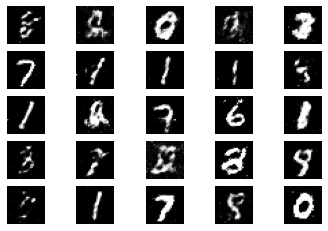

Epoch 20000
20000: [Discriminator loss: 0.621993, acc: 0.477000]  [GAN loss: 1.144136, acc: 0.194000]


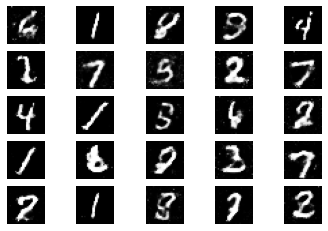

Epoch 30000
30000: [Discriminator loss: 0.602765, acc: 0.362000]  [GAN loss: 1.166122, acc: 0.182000]


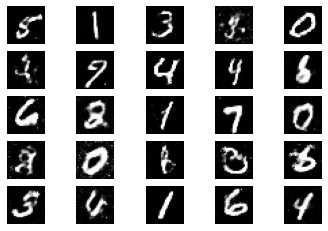

Epoch 40000
40000: [Discriminator loss: 0.599549, acc: 0.444000]  [GAN loss: 0.924486, acc: 0.352000]


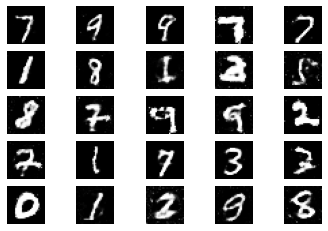

Epoch 50000
50000: [Discriminator loss: 0.565445, acc: 0.371000]  [GAN loss: 1.599627, acc: 0.090000]


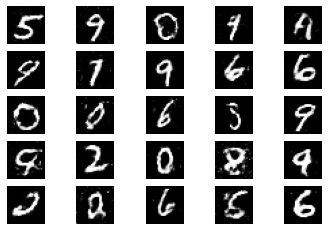

Epoch 60000
60000: [Discriminator loss: 0.651843, acc: 0.227000]  [GAN loss: 1.627897, acc: 0.048000]


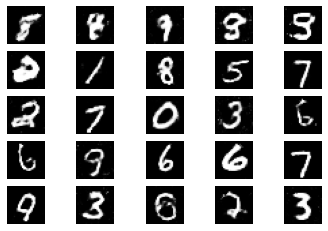

Epoch 70000
70000: [Discriminator loss: 0.542393, acc: 0.439000]  [GAN loss: 1.451734, acc: 0.152000]


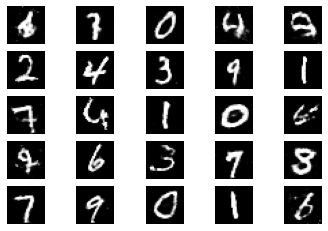

Epoch 80000
80000: [Discriminator loss: 0.589056, acc: 0.414000]  [GAN loss: 1.216592, acc: 0.168000]


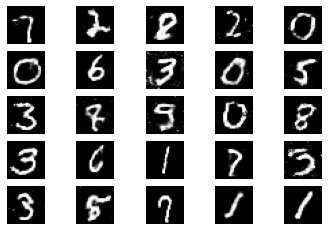

Epoch 90000
90000: [Discriminator loss: 0.600677, acc: 0.451000]  [GAN loss: 0.969144, acc: 0.302000]


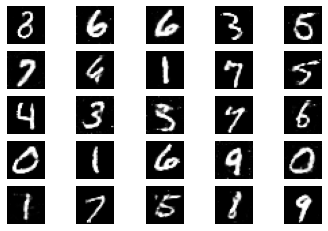

Epoch 100000
100000: [Discriminator loss: 0.591841, acc: 0.472000]  [GAN loss: 0.796583, acc: 0.526000]


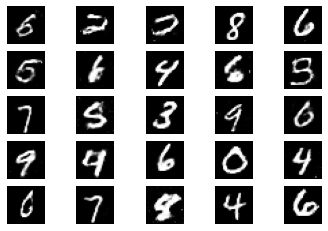

In [2]:
#Load MNIST data and normalize to [-1, 1]
(data_train, _), (data_test, _) = mnist.load_data()
data_train = (data_train/127.5) - 1
data_test = (data_test/127.5) - 1

# The D-dimensional noise vector length
latent_dim = 100

data_dim = 784

# Optimizer for discriminator, which will have a higher learning rate than adversarial model
def adam_optimizer():
    return [adam(learning_rate=0.0002, beta_1=0.5, beta_2=0.999), adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999)] #[discriminator, GAN]

# Genrerator model
def create_generator():
    generator=Sequential()

    generator.add(Dense(250, input_dim=latent_dim)) #Input + 1st layer
    generator.add(LeakyReLU(0.2))

    generator.add(Dense(550))
    generator.add(LeakyReLU(0.2))

    generator.add(Dense(1100))
    generator.add(LeakyReLU(0.2))

    generator.add(Dense(data_dim, activation='tanh')) #data dim

    return generator

# Discriminator model
def create_discriminator():
    discriminator=Sequential()
    
    discriminator.add(Dense(1100, activation=LeakyReLU(0.2), input_dim=data_dim)) #Input + 1st layer
    discriminator.add(Dropout(0.3))
    
    discriminator.add(Dense(550, activation=LeakyReLU(0.2)))
    discriminator.add(Dropout(0.3))

    discriminator.add(Dropout(0.3))
    discriminator.add(Dense(units=250))

    discriminator.add(Dense(units=1, activation='sigmoid'))
    discriminator.compile(loss = keras.losses.binary_crossentropy, optimizer=adam_optimizer()[0], metrics=['accuracy'])

    return discriminator

# Create adversarial model
def create_gan(discriminator, generator):
    discriminator.trainable = False
    gan_input = Input(shape=(latent_dim,))
    x = generator(gan_input)
    gan_output = discriminator(x)
    gan = Model(inputs=gan_input, outputs=gan_output)
    gan.compile(loss=keras.losses.binary_crossentropy, optimizer=adam_optimizer()[1], metrics=['accuracy'])

    return gan

# Creating GAN
generator = create_generator()
discriminator = create_discriminator()
gan = create_gan(discriminator, generator)

# Model and training parameters
epochs = 100000
batch_size = 500
sample_interval = 10000

# Array to save training history
training_meta_data = np.zeros([epochs, 4])

# Training the GAN
for e in range(1, epochs+1):

    # Generate random noise as input
    noise = keras.backend.constant(np.random.normal(loc=0, scale=1, size=(batch_size, latent_dim)))

    # Generate fake MNIST images from generated noise
    fake_images = generator(noise)
    fake_images = tf.reshape(fake_images, (-1,28,28))

    # Get a random set of real MNIST images
    real_images = tf.convert_to_tensor((random.choices(data_train, k=batch_size)), dtype=tf.float32)

    # Concatenate real and fake images into a single array (or batch)
    data_total = tf.concat([real_images, fake_images],0)

    # Assign training labels (assign high probability, but not 1, to real images)
    labels_real = [0.9 for i in range(batch_size)]

    # Allow discriminator parameters to be updated
    labels_fake = [0 for i in range(batch_size)]

    # Train discriminator on batch of real and fake images. Assign loss and accuracy to variable
    labels_discriminator = labels_real + labels_fake
    labels_discriminator = tf.convert_to_tensor(labels_discriminator)
    discriminator.trainable = True #Where we left off...

    # Train adversarial model and try to fool discriminator (with incorrect label) 
    # by generating a new batch of noise and assign them labels of real data
    data_total = tf.reshape(data_total, (-1, 784))
    d_loss = discriminator.train_on_batch(data_total, labels_discriminator)
    noise = np.random.normal(loc=0, scale=1, size=(batch_size, latent_dim))
    labels_generator = np.ones(batch_size)

    # Keep discriminator weights constant while training generator
    discriminator.trainable = False

    # Train GAN (without updating discriminator weights) on new batch of fake images. Assign loss and accuracy to variable
    gan_loss = gan.train_on_batch(noise, labels_generator)

    # Save training status
    # Discriminator and model loss
    training_meta_data[e-1, 0] = d_loss[0]
    training_meta_data[e-1, 1] = gan_loss[0]

    # Discriminator and model accuracy
    training_meta_data[e-1, 2] = d_loss[1]
    training_meta_data[e-1, 3] = gan_loss[1]


    # If at sample interval, print training status and save samples
    if e % sample_interval == 0:
      
        # Print training status
        print("Epoch %d" %e)
        log_mesg = "%d: [Discriminator loss: %f, acc: %f]" % (e, d_loss[0], d_loss[1])
        log_mesg = "%s  [GAN loss: %f, acc: %f]" % (log_mesg, gan_loss[0], gan_loss[1])
        print(log_mesg)
        
        # Plot images 
        r, c = 5, 5

        # Create images from the noise (predict the outcome of the noise)
        gen_imgs = generator.predict(noise)

        # Rescale images 0 - 1
        gen_imgs = 0.5 * gen_imgs + 0.5

        fig, axs = plt.subplots(r, c)
        cnt = 0
        for i in range(r):
            for j in range(c):
                axs[i,j].imshow((gen_imgs[cnt].reshape(28, 28)), cmap='gray')
                axs[i,j].axis('off')
                cnt += 1
        plt.show()

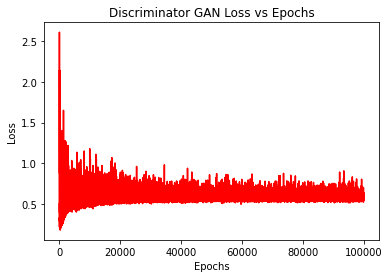

In [12]:
# Plot discriminator model loss vs epoch
plt.plot([a[0] for a in training_meta_data], color="red")

plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Discriminator GAN Loss vs Epochs")

plt.show()

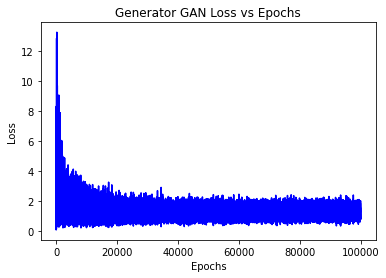

In [16]:
# Plot generator model loss vs epoch
plt.plot([a[1] for a in training_meta_data], color="blue")

plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Generator GAN Loss vs Epochs")

plt.show()

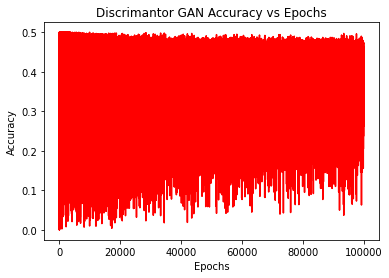

In [17]:
# Plot discriminator accuracy vs epoch
plt.plot([a[2] for a in training_meta_data], color="red", label="discriminator")

plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Discrimantor GAN Accuracy vs Epochs")

plt.show()

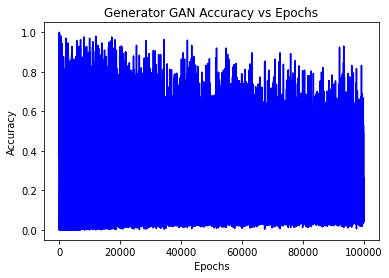

In [18]:
# Plot generator accuracy vs epoch
plt.plot([a[3] for a in training_meta_data], color="blue", label="generator")

plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Generator GAN Accuracy vs Epochs")

plt.show()

[4]. Compare and comment on the results of GAN with dropout and without dropout.

ANS: Without dropout, the discriminator network would be too limited to knowing correct images on very specific characteristics, and with generators, these characteristics would be weighted too heavily regardless of wether or not a correct image was produced. With dropout included, these networks are allowed to generalize more and learn how to better discriminate/generate broadly.

[5][a]. Comment on importance of hyper-parameter tuning

ANS: With hyper-parameter tuning, such as that with ADAM, we can better adjust things we know to be factors in our loss function. As with ADAM, we were able to tune our optimizer to two settings; one for a discriminator, and one for a generator. This tuning allows for each optimizer to be a much better fit for the given networks.

[6]. Answer the following questions:



1.   Why does the accuracy of the discriminator remain around 50%? Is this a good trait of the GAN? 

  ANS: As the GAN progresses (i.e. discriminator and generator learn), the discriminator is somewhat on pace with the level of the generator. Because of this, the discriminator stays to become as good as the generator. This is a somewhat desired trait, as both networks learn/imporve together.


2.   How could this model be modified to produce cleaner (less noisy) images? 

  ANS: The discriminator could be allowed to start at a slightly higher performing level. This would allow for the discriminator to be more sensitive to this noise, which would force the generator to perform better on generating images. Also considering an optimal dropout and batch size may produce the a level of preferred cleanliness.

#Part 2: Generating samples using trained generator

In [5]:
# Generate ten images from Gaussian noise using the trained generator from Part 1
generated_images = list()

for i in range(10):
  noise = keras.backend.constant(np.random.normal(loc=0, scale=1, size=(batch_size, latent_dim)))
  generated_images.append(generator(noise))

generated_images = tf.convert_to_tensor(generated_images)

# Re-scale generated images to lie in [0, 1]
generated_images = np.array((generated_images + 1) / 2)

noise = np.array(noise)

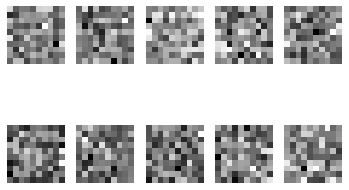

In [6]:
# Visualize generated noise
r, c = 2, 5
fig, axs = plt.subplots(r, c)
cnt = 0
for i in range(r):
    for j in range(c):
        axs[i,j].imshow((noise[cnt].reshape(10, 10)), cmap='gray')
        axs[i,j].axis('off')
        cnt += 1
plt.show()

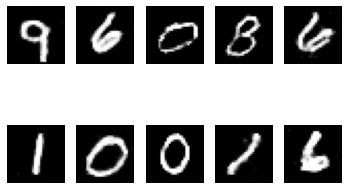

In [7]:
# Visualize generated samples
r, c = 2, 5
fig, axs = plt.subplots(r, c)
cnt = 0
for i in range(r):
    for j in range(c):
        axs[i,j].imshow((generated_images[cnt][0].reshape(28, 28)), cmap='gray')
        axs[i,j].axis('off')
        cnt += 1
plt.show()

#Part 3: Testing accuracy of generated images on ten samples

In [8]:
# Load mnist classifier and generated images
from google.colab import drive
import pandas as pd
drive.mount('/content/drive')
mnist_classifier = load_model('/content/drive/My Drive/ECE 595 DL/mnist_classifier.h5')

Mounted at /content/drive


In [10]:
# ASSIGN CLASSES
labels = []
from keras.utils.np_utils import to_categorical

# Convert integer labels to one-hot labels 
labels = keras.utils.np_utils.to_categorical(labels, num_classes=10)

classifications = []

# Show classifications
print("Classifications: ")
for i in range(len(generated_images)):
  classifications.append(mnist_classifier.test_on_batch(generated_images[i]))
  print(f'{i}: {classifications[i][0]}')

# Evaluate accuracy
print("Accuracy: ")
for i in range(len(generated_images)):
  print(f'{i}: {classifications[i][1]}')

Classifications: 
0: 0.0
1: 0.0
2: 0.0
3: 0.0
4: 0.0
5: 0.0
6: 0.0
7: 0.0
8: 0.0
9: 0.0
Accuracy: 
0: 0.0
1: 0.0
2: 0.0
3: 0.0
4: 0.0
5: 0.0
6: 0.0
7: 0.0
8: 0.0
9: 0.0


[3a] State the accuracy of the classifier on your ten generated images. Based on this accuracy, would you say your generator does well in producing images comparable to those in the MNIST dataset of hand-written digits? Why or why not?:

ANS: The accuracy of the classifier on the ten generated images is low. Based on this accuracy, I would say that my generator is not a well performer in producing images comparable to the MNIST dataset. I believe that with adequate computing resources, this model may produce higher accuracy. The model above trained for 8+ hours with just batch_size=1000. Due to my limited google colab access and machine privledges, I stook with a smaller batch size to complete this assignment. I learned now that this design decision does underutilize computational resources, however it comes at the cost of not having more accurate gradient estimates that larger batch sizes enable. 

[3b] In this project, we only tested the performance of the pre-trained classifier on ten samples and used its result to determine the robustness of the generator. How could we better assess the quality of the generated images using this pre-trained classifier and the saved generator?:

ANS: We could try on a much larger scale (with many epochs) to try and train the generator network in an attempt to have it learn and to beat the much more sensetive pre-trained classifier.